# Detecting Coconut Trees from the Air in the South Pacific (Tonga)

![tile05](tile05.jpg)

## Motivation & Sources

- https://werobotics.org/blog/2018/01/10/open-ai-challenge/
- https://docs.google.com/document/d/16kKik2clGutKejU8uqZevNY6JALf4aVk2ELxLeR-msQ/edit

> In collaboration with WeRobotics and OpenAerialMap, the World Bank’s UAVs for Disaster Resilience Program captured ~80km2 of high resolution (under 10 cm) aerial imagery in the Kingdom of Tonga in October 2017. The World Bank now seek qualified teams to develop machine learning classifiers to automate the analysis of this imagery. The classifiers will also be applied to new imagery to speed up baseline analysis and damage assessments in the future. 


> Being able to quantify the number of trees that serve as an important source of livelihood  for local communities is essential. These trees and their locations can then be compared before and after major disasters to better understand just how much local agriculture and hence food security has been affected. This can directly inform and accelerate subsequent relief efforts. The focus on roads is also meant to help identify the impact of natural disasters on local transportation infrastructure and to inform how best to distribute aid across affected areas.

- original GeoTIFF file: https://map.openaerialmap.org/#/-175.34310311079025,-21.097543257642922,18/square/20002233030/5a28640ebac48e5b1c58a81d?_k=a2zw5d
- original annotations file: https://drive.google.com/file/d/1rumWHzO3_CO40uXhaP69roUyfFzYCe20

> Note: The aerial imagery provided for this challenge is under a CC-BY creative commons license. The OSM training data (roads, building, trees, ets) is provided under the Open Data Commons Open Database License (ODbL).

## 4 tree types annotated as lon/lat point coordinates:
- coconut: Cocos nucifera **<-- In these notebooks, we are focused on detecting coconut trees only (single class)**
- mango: Mangifera indica
- banana: Musaceae, Musa
- papaya: Carica papaya
- other points annotated: population centers, power poles, manmand barriers and misc. fixtures

## Pre-processing overview:

![coconut-preprocessing-steps](Coconut-preprocessing-steps.jpg)

## Notebooks summary:
### 1. "coconuts-tilegen":
- Reproject original GeoTIFF to WGS 84 
- Create tiles and convert lat, lon to x,y display offset coordinates for all trees within each tile (15 tiles)


### 2. "coconuts-imagegen":
- Generate 224px x 224px patches for each tile.
- Convert x,y offsets for each tree point into square bbox coordinates (or rectangles at the borders)
- Filter out patches that do not contain any trees
- Save remaining patches as jpeg images with corresponding bbox and category labels (4062 jpg files)

### 3. "coconuts-model":
- Load jpegs and bbox/cat labels into model notebook and train away!

# Postprocessed Dataset Download

**Use this notebook with final postprocessed training files (after tilegen and imagegen) **

1. Download jpeg images and bbox/cat labels here (50MB): https://www.dropbox.com/s/g4isvnc577bg6ud/coconuts_0329_train.zip?dl=0

2. Unzip into your project data folder (i.e. 'data/tonga/')

3. Unzipped file structure should look like:
```
── train
       ├── jpegs
             ├── 4063 jpeg files
       ├── mbb_noempties.csv
       ├── mc_noempties.csv 
       ├── models
       ├── tmp
```

# Setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

import pandas as pd

In [3]:
PATH = Path('data/tonga/train')
JPEGS = 'jpegs'
IMG_PATH = PATH/JPEGS
CSV_SUFFIX = 'noempties'

df = pd.read_csv(PATH/f'mc_{CSV_SUFFIX}.csv')
df2 = pd.read_csv(PATH/f'mbb_{CSV_SUFFIX}.csv')

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

In [5]:
df.head()

fn                                    clas
0  000000.jpg               coconut_tree coconut_tree
1  000001.jpg                            coconut_tree
2  000002.jpg               coconut_tree coconut_tree
3  000003.jpg               coconut_tree coconut_tree
4  000004.jpg  coconut_tree coconut_tree coconut_tree

In [6]:
df2.head()

fn                                     bbox
0  000000.jpg                 0 97 53 187 168 0 224 72
1  000001.jpg                           54 166 144 224
2  000002.jpg           156 141 224 224 15 168 105 224
3  000003.jpg             120 59 210 149 19 90 109 180
4  000004.jpg  81 121 171 211 165 67 224 157 7 0 97 77

In [7]:
df_all = pd.merge(df, df2, on='fn')
df_all.head()

fn                                    clas  \
0  000000.jpg               coconut_tree coconut_tree   
1  000001.jpg                            coconut_tree   
2  000002.jpg               coconut_tree coconut_tree   
3  000003.jpg               coconut_tree coconut_tree   
4  000004.jpg  coconut_tree coconut_tree coconut_tree   

                                      bbox  
0                 0 97 53 187 168 0 224 72  
1                           54 166 144 224  
2           156 141 224 224 15 168 105 224  
3             120 59 210 149 19 90 109 180  
4  81 121 171 211 165 67 224 157 7 0 97 77

In [8]:
df_all.shape

(4063, 3)

# Process Label CSVs and Create Trn and Val sets

In [9]:
MBB_CSV = PATH/f'mbb_{CSV_SUFFIX}.csv'
CLAS_CSV = PATH/f'mc_{CSV_SUFFIX}.csv'

In [10]:
MBB_CSV, CLAS_CSV

(PosixPath('data/tonga/train/mbb_noempties.csv'),
 PosixPath('data/tonga/train/mc_noempties.csv'))

In [11]:
f_model = resnet34
sz = 224
bs = 64

In [12]:
# manually defining categories since there's only one (coconut_tree). 
# Using {1: 'banana_tree'} as a hack to help with debugging zeropadded cat labels later on. There are no actual banana_tree labels

cats = {
    1: 'banana_tree',
    2: 'coconut_tree'
}

In [13]:
id2cats = list(cats.values())

In [14]:
trn_ids = [int(str(o['fn']).split('.')[0]) for i, o in df_all.iterrows()]
#trn_ids

In [15]:
trn_fns = dict((trn_ids[i], df['fn'][i]) for i,o in df.iterrows())
#trn_fns

In [16]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for i,o in df_all.iterrows():
        #print(o)
        bb = o['bbox']
        bb = bb.split(' ')
        bb = np.asarray(bb).astype(int)
        #print(bb)
        num_bb = int(len(bb)/4)
        for j in range(num_bb):
            bb_4 = bb[j*4:j*4+4]
            each_bb = np.array([bb_4[0], bb_4[1], bb_4[2], bb_4[3]]) # bbox in y_min, x_min, y_max, x_max order
            #print(each_bb)
            trn_anno[trn_ids[i]].append((each_bb,2))
    return trn_anno

trn_anno = get_trn_anno()

In [17]:
trn_anno[0], trn_anno[1], trn_anno[2]

([(array([  0,  97,  53, 187]), 2), (array([168,   0, 224,  72]), 2)],
 [(array([ 54, 166, 144, 224]), 2)],
 [(array([156, 141, 224, 224]), 2), (array([ 15, 168, 105, 224]), 2)])

In [18]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
mc[:3]

[['coconut_tree', 'coconut_tree'],
 ['coconut_tree'],
 ['coconut_tree', 'coconut_tree']]

In [19]:
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])
mcs[:3]

array([array([1, 1]), array([1]), array([1, 1])], dtype=object)

In [20]:
len(mcs)

4063

In [21]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)
len(val_mcs), len(trn_mcs)

(812, 3251)

# Model creation

In [22]:
# Rotations and mirrors, random rotate
aug_tfms = [RandomDihedral(tfm_y=TfmType.COORD),
            #RandomRotate(15,0.25,tfm_y=TfmType.COORD),
            #RandomZoom(.30,0,tfm_y=TfmType.COORD),
           ]

In [23]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=aug_tfms, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True)

In [24]:
md.val_ds.fnames[:5]

array(['jpegs/000006.jpg', 'jpegs/000008.jpg', 'jpegs/000012.jpg', 'jpegs/000014.jpg', 'jpegs/000017.jpg'],
      dtype='<U16')

In [25]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [26]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [27]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [28]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [29]:
md.trn_ds[0]

(array([[[ 0.19394,  0.10831,  0.05694, ...,  1.52967,  1.37555,  1.4098 ],
         [ 0.10831,  0.21106,  0.24531, ...,  1.54679,  1.25567,  1.3413 ],
         [-0.16568,  0.15969,  0.27956, ...,  1.46117,  1.11867,  1.2728 ],
         ...,
         [-1.22742, -1.21029, -1.24454, ...,  0.03981, -0.28556, -0.47393],
         [-1.10754, -1.09042, -1.12467, ...,  0.29669, -0.06293, -0.3883 ],
         [-0.97055, -0.95342, -1.00479, ...,  0.89605,  0.43368, -0.18281]],
 
        [[ 0.36275,  0.27521,  0.22269, ...,  1.86835,  1.7458 ,  1.78081],
         [ 0.27521,  0.38025,  0.41527, ...,  1.88585,  1.62325,  1.71078],
         [-0.0049 ,  0.32773,  0.45028, ...,  1.79832,  1.44818,  1.60574],
         ...,
         [-0.88025, -0.86274, -0.88025, ...,  0.27521, -0.10994, -0.30252],
         [-0.7402 , -0.72269, -0.7577 , ...,  0.52031,  0.10014, -0.23249],
         [-0.60014, -0.58263, -0.63515, ...,  1.13305,  0.60784, -0.02241]],
 
        [[ 0.39163,  0.30449,  0.2522 , ...,  1.21081,

In [30]:
x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)

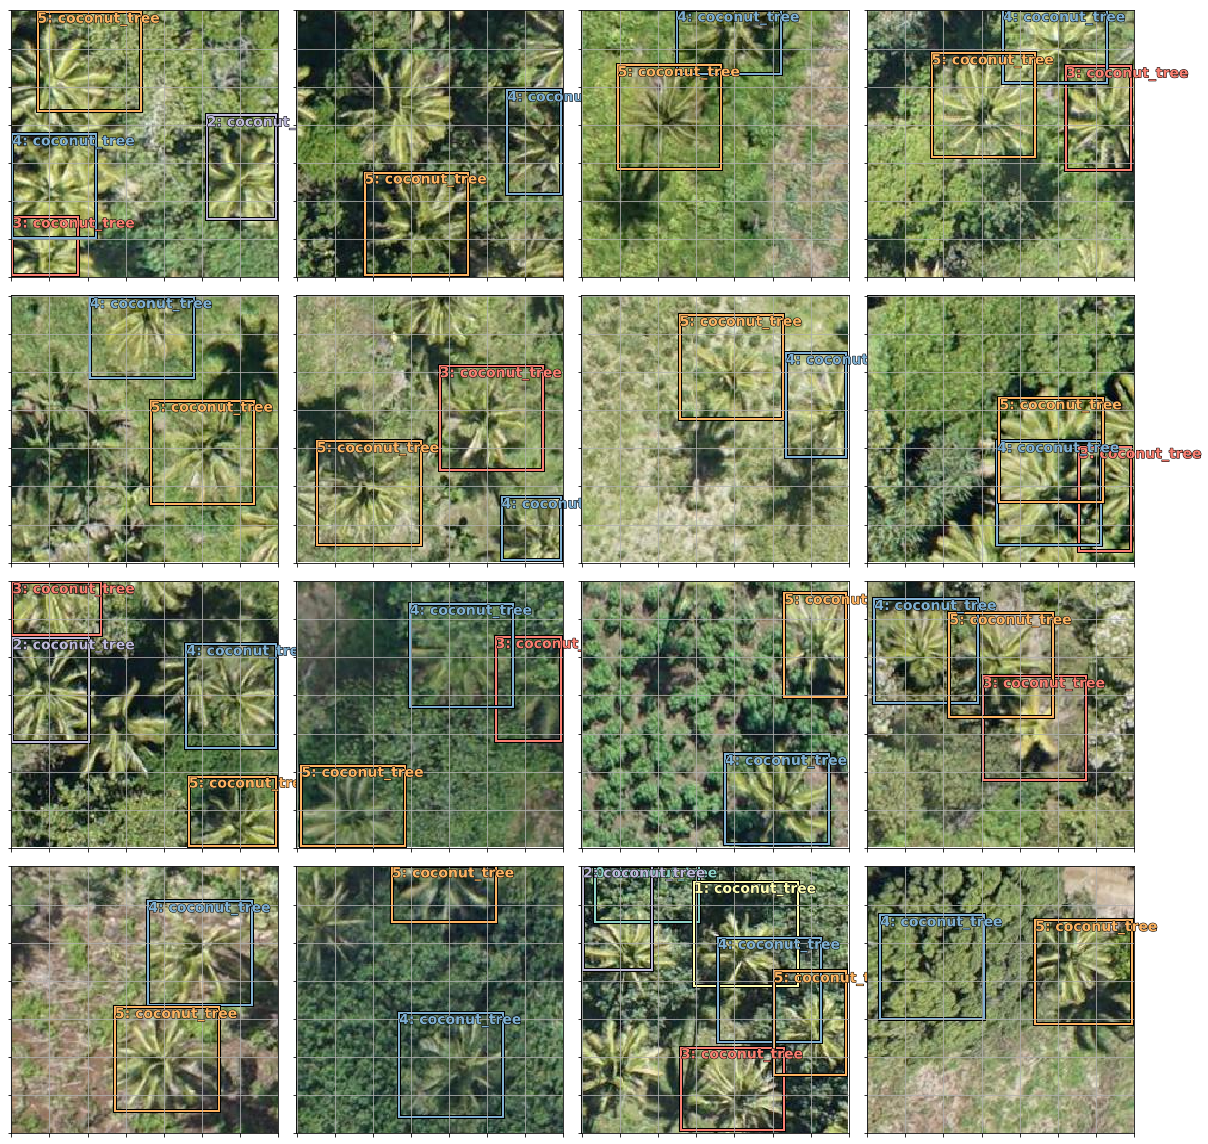

In [31]:
# sanity check augmentations and correctly transformed bounding boxes in trn_ds
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i], prs=None, thresh=0.)
plt.tight_layout()

In [32]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

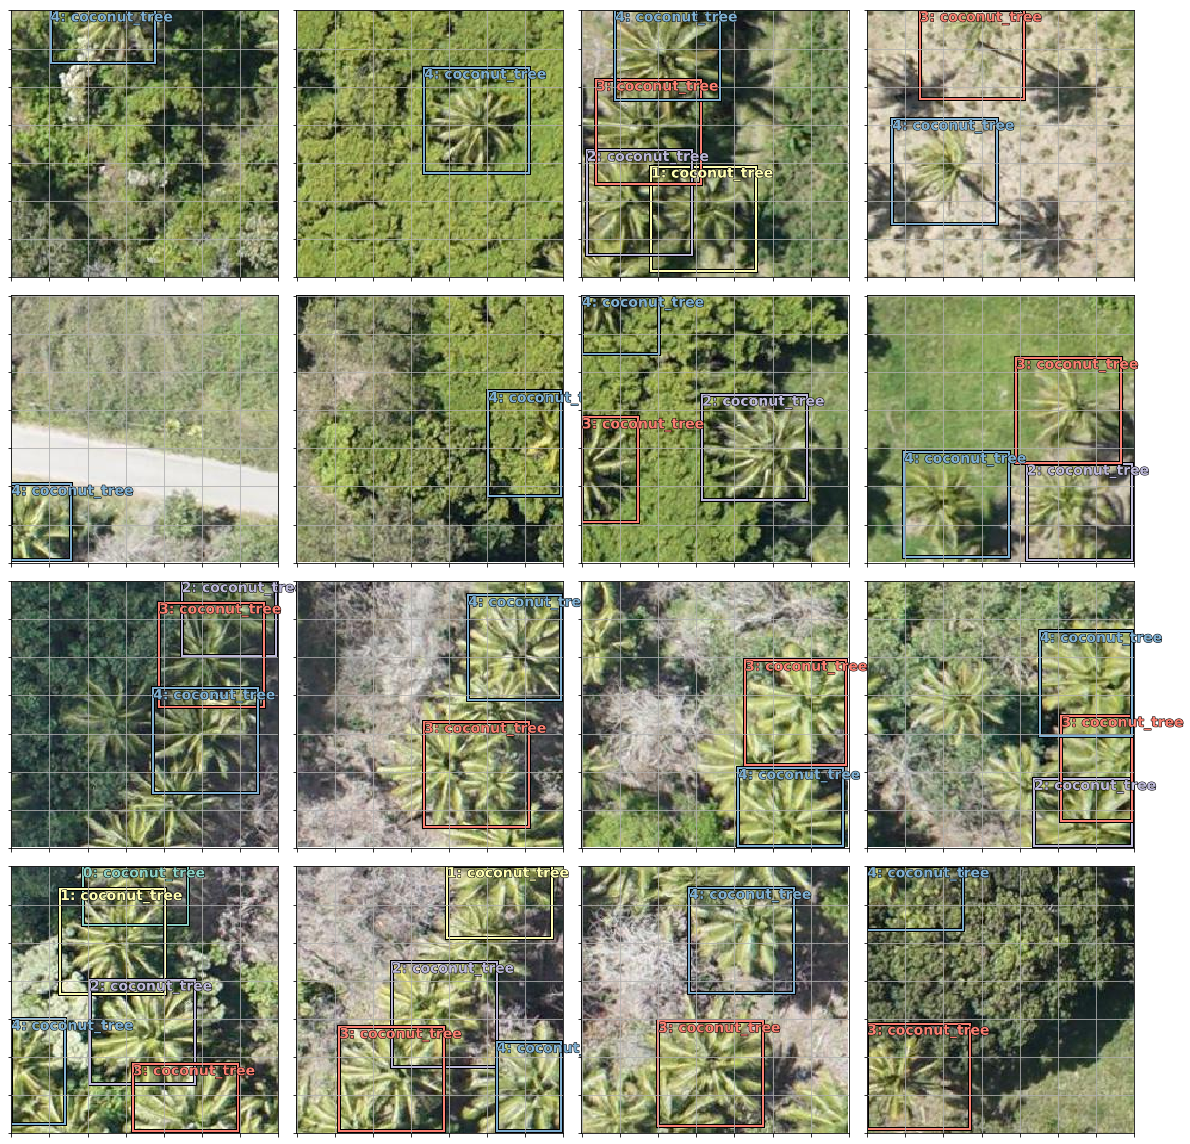

In [33]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for i,ax in enumerate(axes.flat):
    #i = i+20
    show_ground_truth(ax, x[i], y[0][i], y[1][i], prs=None, thresh=0.)
plt.tight_layout()

# Model-related base functions all in one place

In [34]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [35]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [36]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [37]:
def get_y(bbox,clas):
    #pdb.set_trace()
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    #if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    #pdb.set_trace()
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs


In [38]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [39]:
def plot_results(starting_idx, thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    for idx,ax in enumerate(axes.flat):
        idx = idx+starting_idx
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

# Custom Anchors and Model

In [40]:
anc_grids = [28,14,7,4,2]
anc_zooms = [2**(0/3),2**(1/3),2**(2/3)]
anc_ratios = [(1.,1.), (.5,1.), (1.,.5)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [41]:
len(anchors), k

(9441, 9)

In [42]:
class StdConv(nn.Module):
    def __init__(self, n_in,n_out,stride=2,dp = 0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in,n_out,3,stride=stride,padding=1)
        self.bn = nn.BatchNorm2d(n_out)
        self.dropout = nn.Dropout(dp)
        
    def forward(self,x):
        return self.dropout(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,3,2,1).contiguous()
    return x.view(bs,-1,nf//k) 

In [43]:
class OutConv(nn.Module):
    def __init__(self, k, n_in, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(n_in, (len(id2cats)+1) * k, 3, padding=1)
        self.oconv2 = nn.Conv2d(n_in, 4 * k, 3, padding = 1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self,x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [44]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [45]:
cut,lr_cut = model_meta[f_model]
def get_base():
    layers = cut_model(f_model(True), cut)
    return nn.Sequential(*layers)

In [47]:
drop = 0.4

class SSD_Custom_noFPN1(nn.Module):
    def __init__(self, m_base, k, bias):
        super().__init__()
        self.m_base = m_base
        
        # bottom up 
        self.sfs = [SaveFeatures(m_base[i]) for i in [5,6]] # 28x28 & 14x14
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512,256, dp=drop, stride=1) # 7x7
        self.sconv2 = StdConv(256,256, dp=drop) # 4x4
        self.sconv3 = StdConv(256,256, dp=drop) # 2x2
        self.sconv4 = StdConv(256,256, dp=drop) # 1x1
                  
        # lateral
        self.lat1 = nn.Conv2d(128,256, kernel_size=1, stride=1, padding=0)

        # outconvs
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
        self.out4 = OutConv(k, 256, bias)
        self.out5 = OutConv(k, 256, bias)
        self.out6 = OutConv(k, 256, bias)
        
    def forward(self, x):
#         pdb.set_trace()
        x = self.drop(F.relu(self.m_base(x))) 
        
        c1 = self.lat1(self.sfs[0].features) # 128, 28, 28
        c2 = self.sfs[1].features # 256, 14, 14     
        c3 = self.sconv1(x)         # 256, 7, 7
        c4 = self.sconv2(c3)       # 256, 4, 4
        c5 = self.sconv3(c4)      # 256, 2, 2
        c6 = self.sconv4(c5)      # 256, 1, 1
            
        o1c,o1l = self.out1(c1)
        o2c,o2l = self.out2(c2)
        o3c,o3l = self.out3(c3)
        o4c,o4l = self.out4(c4)
        o5c,o5l = self.out5(c5)
#        o6c,o6l = self.out6(p6)
        
        return [torch.cat([o1c,o2c,o3c,o4c,o5c], dim=1),
                torch.cat([o1l,o2l,o3l,o4l,o5l], dim=1)]
    

In [48]:
class MakeModel():
    def __init__(self,model,name='makemodel'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.m_base), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [49]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,2.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

In [50]:
m_base = get_base()
m = to_gpu(SSD_Custom_noFPN1(m_base,k,-4))
models = MakeModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = partial(optim.SGD,momentum=0.9)
learn.crit = ssd_loss

# Train

In [51]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
batch = learn.model(x)

In [52]:
ssd_loss(batch, y, True)

loc: 5.203292369842529, clas: 496.9496154785156


Variable containing:
 502.1529
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [53]:
lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])

In [54]:
learn.lr_find(lr/1000,lr*1e4)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 53%|█████▎    | 27/51 [00:16<00:14,  1.62it/s, loss=1.88e+03]

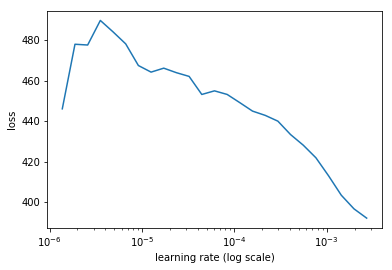

In [55]:
learn.sched.plot(1,1)

In [52]:
version_str='_nofpn_a_0417'

In [57]:
learn.fit(lrs, 1, cycle_len=5, use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  6%|▌         | 3/51 [00:05<01:27,  1.82s/it, loss=440]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                           
    0      192.363134 116.295562
    1      142.055911 101.221294                         
    2      122.368472 95.516779                          
    3      112.957924 93.100763                          
    4      108.531585 91.749969                          



[91.74996895625674]

In [58]:
lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])
learn.unfreeze()
learn.lr_find(start_lr = lrs/1000, end_lr = lrs*100, wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|████████  | 41/51 [00:29<00:07,  1.38it/s, loss=3.12e+04]

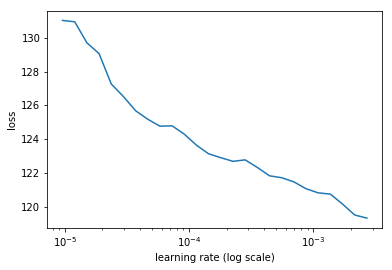

In [59]:
learn.sched.plot()

In [60]:
learn.fit(lrs,1,cycle_len=20, use_clr_beta=(10,10,0.95,0.85), wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

  6%|▌         | 3/51 [00:05<01:34,  1.97s/it, loss=132]      


Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                           
    0      104.499645 82.697012 
    1      94.152782  76.973734                           
    2      88.372176  75.895597                           
    3      84.836646  73.83028                            
    4      82.411741  73.484656                           
    5      79.868503  72.20234                            
    6      78.4167    72.061628                           
    7      77.291752  72.135804                           
    8      75.903978  70.659388                           
    9      74.58538   70.777557                           
    10     73.465501  70.821985                           
    11     72.084299  70.776036                           
    12     71.240978  70.832854                           
    13     70.029417  71.257406                           
    14     68.76276   70.124427                           
    15     67.487409  70.897819                           
    16     66.598089  70

[70.20563736337746]

In [61]:
learn.save(f'coconuts_custom{version_str}_02')

# NMS

In [53]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

# Evaluate Model with Precision and Recall

In [54]:
learn.load(f'coconuts_custom{version_str}_02')
learn.model.eval()

SSD_Custom_noFPN1(
  (m_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), st

In [55]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
x = to_np(x)

In [56]:
ssd_loss(batch, y, True)

loc: 1.767189860343933, clas: 70.14553833007812


Variable containing:
 71.9127
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [57]:
def get_pred(idx, x, y, batch, md_thres=0.35, display=False):

    b_clas, b_bb = batch
    bbox, clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > md_thres
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
        
    # setting -1s to prevent an empty tensor error if no predictions > model_thres
    if not cc: cc = T([-1])
    else: cc = T(np.concatenate(cc)) 
    if not out1: out1 = T([[-1.,]])
    else: out1 = torch.cat(out1)
    if not out2: out2 = T([[-1., -1., -1., -1.]])
    else: out2 = torch.cat(out2)
        
    pr = (cc, out1, out2) # class, conf, bb
    gt = (clas.data, bbox.data) # class, bb
    
    if display:
        ima=md.val_ds.ds.denorm(x)[idx]
        show_img_3col(ima, pr, gt)
    
    return pr, gt 

In [58]:
def show_img_3col(ima, pr, gt):
    pr_cl, pr_conf, pr_bb = pr
    gt_cl = gt[0]
    gt_bb = gt[1]
    
    #ima=md.val_ds.ds.denorm(x)[idx]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 45))
    torch_gt(ax1, ima, pr_bb, pr_cl, pr_conf, 0.)
    
    if to_np(pr_conf)[0] >= 0: str_obj = str(len(pr_conf)) 
    else: str_obj = '0'
    title1_str = '# detected: '+ str_obj
    ax1.text(0,-10,title1_str)

    torch_gt(ax2, ima, gt_bb, gt_cl, None, 0.)
    title2_str = '# GT objects: '+ str(len(gt_cl))
    ax2.text(0,-10,title2_str)

    show_img(ima, ax=ax3)
    ax3.grid(False)
    
    plt.show()

In [59]:
# count TP, FP, FN for a single image in a single class, assuming that class is in both prediction and ground truth

def tpfpfn_1img(conf_pr, bb_pr, bb_gt, thres):
    '''
    mostly borrowed from https://gist.github.com/tarlen5/008809c3decf19313de216b9208f3734 starting line 80
    ''' 
    
    # calc IoUs for every prediction to every gt object. If > threshold, add to idx counters
    pr_overthres_idx = []
    gt_overthres_idx = []
    #ious_overthres = [] # sort by confidence instead of IoU
    conf_overthres = []
    for i, pr in enumerate(bb_pr):
        for j, gt in enumerate(bb_gt):
            pr = T(pr).cpu()
            gt = T(gt).cpu()

            overlap = to_np(jaccard(gt.unsqueeze(0), pr.unsqueeze(0)))
            if overlap >= thres:
                #print(i, j, overlap)
                pr_overthres_idx.append(i)
                gt_overthres_idx.append(j)
                #ious_overthres.append(float(overlap))
                conf_overthres.append(conf_pr[i])
    
    # sort idx in order of highest confidence first, change from IoU sorting approach
    idxsorted = np.argsort(conf_overthres)[::-1]
    
    # for each match, check if already counted as detected or not. if not, add to idx counter
    gt_match_idx = []
    pr_match_idx = []
    for idx in idxsorted:
        gt_idx = gt_overthres_idx[idx]
        pr_idx = pr_overthres_idx[idx]
        #print(id_pred_overthres[idx], id_gt_overthres[idx])
        if pr_idx not in pr_match_idx and gt_idx not in gt_match_idx:
            gt_match_idx.append(gt_idx)
            pr_match_idx.append(pr_idx)

    tp = len(gt_match_idx)
    fp = len(bb_pr) - len(pr_match_idx)
    fn = len(bb_gt) - tp
    
    return tp, fp, fn

In [60]:
def oneclass_tpfpfn_1img(cat, idx, pr, gt, iou_thres):
    
    pr_cl, pr_conf, pr_bb = pr
    gt_cl = gt[0]
    gt_bb = gt[1]
    
    pr_cl = pr_cl.cpu()
    pr_conf = pr_conf.cpu()
    pr_bb = pr_bb.cpu()
    gt_cl = gt_cl.cpu()
    gt_bb = gt_bb.cpu()

    tp = 0
    fp = 0
    fn = 0
    
    if cat in pr_cl and cat in gt_cl:
        bb_gt = gt_bb[list(np.argwhere(cat == gt_cl))]
        bb_pr = pr_bb[list(np.argwhere(cat == pr_cl))]
        tp, fp, fn = tpfpfn_1img(pr_conf, bb_pr, bb_gt, iou_thres)
        
    elif cat in pr_cl and cat not in gt_cl: # every detection counts as a false pos
        fp = len(pr_bb[list(np.argwhere(cat == pr_cl))]) 
        
    elif cat not in pr_cl and cat in gt_cl: # every gt obj counts as a false neg
        fn = len(gt_cl[list(np.argwhere(cat == gt_cl))]) 
        
    gt_c = len(np.argwhere(to_np(gt[0])==cat))
    return tp,fp,fn,gt_c

In [61]:
def nclass_tpfnfn_1img(cats, idx, x,y,batch, md_thres=0.25, iou_thres=0.5, display=True, verbose=True):
    pr, gt = get_pred(idx,x,y,batch, md_thres, display)
    
    if verbose: print('TP FP FN GTc   Category')
        
    for cat in cats:
        cl_str = id2cats[cat]
        tp,fp,fn,gt_c = oneclass_tpfpfn_1img(cat, idx, pr, gt, iou_thres)
        
        if verbose: 
            if np.any([tp,fp,fn,gt_c]): print(f'{tp}  {fp}  {fn}  {gt_c}      {id2cats[cat]} (cat{cat})')  

In [62]:
def count(L):
    result = collections.defaultdict(int)
    if L is not None:
        for x in L:
            result[x] += 1
    return result

In [63]:
def all_tpfpfn(md_thres_rng, iou_thres, cats):

    start = time.time()

    tps = np.zeros((len(id2cats), len(md_thres_rng)))
    fps = np.zeros((len(id2cats), len(md_thres_rng)))
    fns = np.zeros((len(id2cats), len(md_thres_rng)))
    gt_c = np.zeros(len(id2cats))
    b_count = 0

    for data in md.val_dl:
        x,y = data
        y = V(y)
        batch = learn.model(V(x))
        b_clas,b_bb = batch
        #x = to_np(x)
        b_count +=1

        for idx in range(len(y[0])):     
            pr, gt = get_pred(idx, x, y, batch, np.min(md_thres_rng)) # get preds at min md_thres, mask later

            # mask for preds where conf > thres at each md_thres step. major speed up (40min -> 2min)
            # inspired by @sgugger nb cell 168: https://github.com/sgugger/Deep-Learning/blob/master/mAP/Computing%20the%20mAP%20metric.ipynb
            for i, md_thres in enumerate(md_thres_rng):
                if np.any(to_np(pr[1]) > md_thres): 
                    masked_idx = T(np.argwhere(to_np(pr[1]) > md_thres)).squeeze() 
                else: break

                pr_masked = (pr[0][masked_idx], pr[1][masked_idx], pr[2][masked_idx])

                for cat in cats:
                    tp,fp,_,_ = oneclass_tpfpfn_1img(cat, idx, pr_masked, gt, iou_thres)
                    tps[cat,i] += tp
                    fps[cat,i] += fp

            # calc FNs separately because pr masking and loop break above misses FNs at higher thresh where there are no predictions
            for cat in cats: gt_c[cat] += count(list(gt[0]))[cat]
            fns = np.repeat(np.expand_dims(gt_c, axis=1),n, axis=1) - tps

        print(f'finished with batch {b_count}')

    end = time.time(); print((end - start)/60)
    
    return tps, fps, fns, gt_c

In [64]:
n = 40
md_thres_rng = np.linspace(.05, 0.95, n, endpoint=True)
iou_thres = 0.5
cats = [1]

tps1, fps1, fns1, gt_c1 = all_tpfpfn(md_thres_rng, iou_thres, cats)

finished with batch 1
finished with batch 2
finished with batch 3
finished with batch 4
finished with batch 5
finished with batch 6
finished with batch 7
finished with batch 8
finished with batch 9
finished with batch 10
finished with batch 11
finished with batch 12
finished with batch 13
0.6357354482014974


# AP @ 0.5

In [65]:
def avg_prec(precisions, recalls):
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    return np.array(prec_at_rec).mean()

In [66]:
def calc_prec_reca(tps, fps, fns, cat):
    eps = np.spacing(1)
    precision = tps[cat,:] / (tps[cat,:]+fps[cat,:]+eps)
    recall = tps[cat,:] / (tps[cat,:]+fns[cat,:])
    ap = avg_prec(precision, recall)
    
    return ap, precision, recall

In [67]:
def draw_prcurves(tps, fps, fns):
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    aps = []

    for i,ax in enumerate(axes.flat):  
        ap, precision, recall = calc_prec_reca(tps, fps, fns, i)
        aps.append(ap)
        ax.plot(recall, precision)
        ax.set_xlim(0,1.1)
        ax.set_ylim(0,1.1)
        ax.set_title(f'cat {i} {id2cats[i]}, AP: {ap:4.4f}')
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')

    plt.tight_layout()
    
    return aps

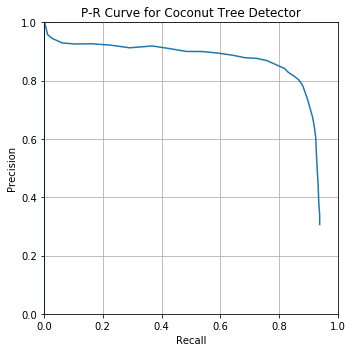

In [68]:
aps = []

fig, ax = plt.subplots(1,1,figsize=(5,5))
ap, precision, recall = calc_prec_reca(tps1, fps1, fns1, 1)
aps.append(ap)
ax.plot(recall, precision)
ax.set_xlim(0,1.0)
ax.set_ylim(0,1.0)
ax.set_title(f'P-R Curve for Coconut Tree Detector')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(1)
plt.tight_layout()

In [69]:
aps

[0.8080251296383385]

In [70]:
def f1_score(precision, recall):
    eps = np.spacing(1)
    return 2 * (precision * recall) / ((precision + recall)+eps)

In [74]:
f1 = f1_score(precision, recall)

In [75]:
best_md_thres = md_thres_rng[np.argmax(f1)]
best_md_thres

0.35

In [76]:
f1.max()

0.8337861200296368

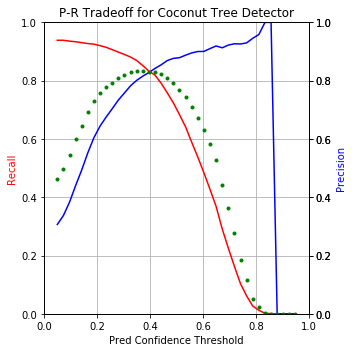

In [77]:
fig, ax1 = plt.subplots(1,1, figsize=(5,5))

ax1.set_xlim(0,1.0)
ax1.set_ylim(0,1.0)

ax1.grid(1)

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax2.set_xlim(0,1.0)
ax2.set_ylim(0,1.0)

ax1.plot(md_thres_rng, recall, 'r-')
ax2.plot(md_thres_rng, precision, 'b-')
ax3.plot(md_thres_rng, f1, '.g')

ax3.set_ylim(0,1.0)

ax1.set_title(f'P-R Tradeoff for Coconut Tree Detector')
ax1.set_xlabel('Pred Confidence Threshold')

ax1.set_ylabel('Recall', color='r')
ax2.set_ylabel('Precision', color='b')

plt.tight_layout()

In [78]:
# collect all the xs and ys in val_ds
full_x = []
full_y = []

for data in md.val_dl:
    x1,y1 = data
    y1 = V(y1)
    full_x.append(x1)
    full_y.append(y1)

In [79]:
def find_allgt_cat(search_cat):
    found_objs = []

    for b, (b_bb, b_c) in enumerate(full_y):
        for j, line in enumerate(b_c.data):
            if search_cat in line: found_objs.append((b,j,list(to_np(line))))
        
    return found_objs # gives which batch, which index in batch, and array of cats within img

In [80]:
def show_foundobjs_threshrange(batch_num, img_idx, threshrange, verbose=True):
    x = full_x[batch_num]
    y = full_y[batch_num]
    
    y = V(y)
    batch = learn.model(V(x))
    x = to_np(x)
    
    for md_thres in threshrange:
        if verbose: print(f'\nNMS CONFIDENCE THRESHOLD: {md_thres:2.2f}')
        nclass_tpfnfn_1img(range(len(id2cats)), img_idx, x, y, batch,  md_thres=md_thres, iou_thres=0.5, verbose=verbose)

In [81]:
search_cat = 1
found_objs = find_allgt_cat(search_cat)
found_objs[:5]

[(0, 0, [0, 0, 0, 0, 1]),
 (0, 1, [0, 0, 0, 0, 1]),
 (0, 2, [0, 1, 1, 1, 1]),
 (0, 3, [0, 0, 0, 1, 1]),
 (0, 4, [0, 0, 0, 0, 1])]

43

NMS CONFIDENCE THRESHOLD: 0.35


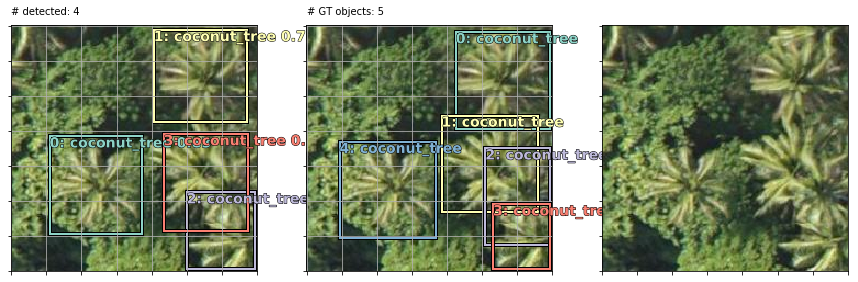

TP FP FN GTc   Category
4  0  1  5      coconut_tree (cat1)

NMS CONFIDENCE THRESHOLD: 0.35


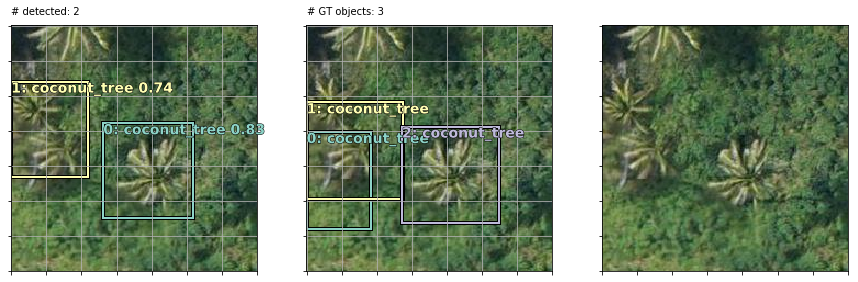

TP FP FN GTc   Category
2  0  1  3      coconut_tree (cat1)

NMS CONFIDENCE THRESHOLD: 0.35


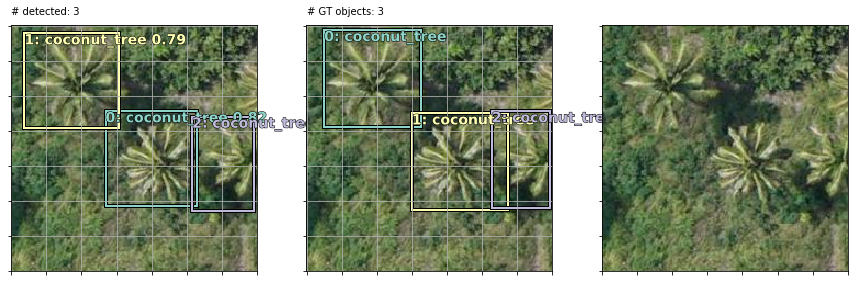

TP FP FN GTc   Category
3  0  0  3      coconut_tree (cat1)

NMS CONFIDENCE THRESHOLD: 0.35


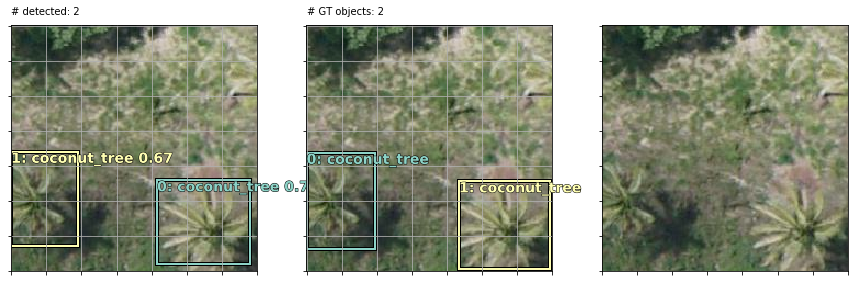

TP FP FN GTc   Category
2  0  0  2      coconut_tree (cat1)

NMS CONFIDENCE THRESHOLD: 0.35


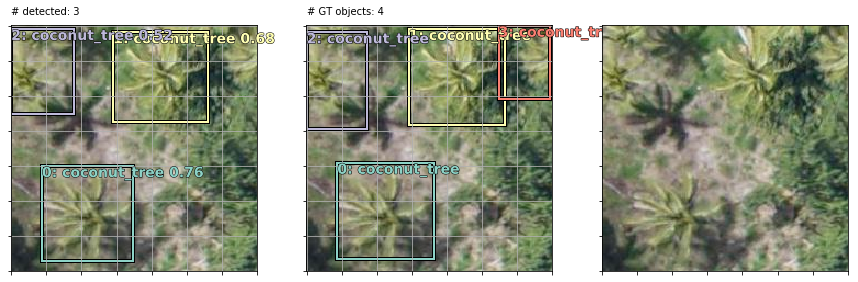

TP FP FN GTc   Category
3  0  1  4      coconut_tree (cat1)

NMS CONFIDENCE THRESHOLD: 0.35


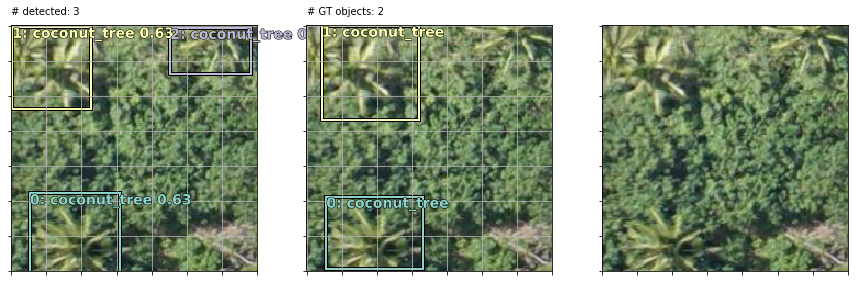

TP FP FN GTc   Category
2  1  0  2      coconut_tree (cat1)

NMS CONFIDENCE THRESHOLD: 0.35


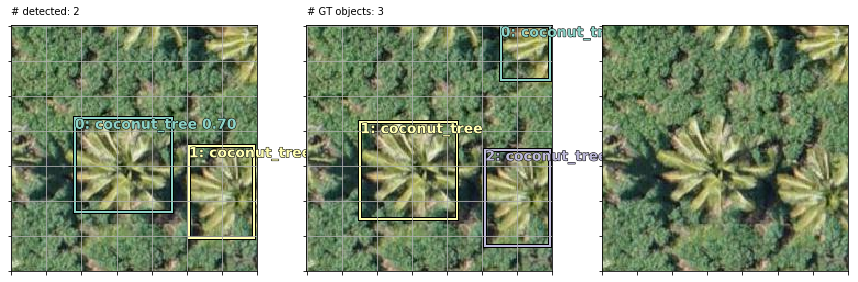

TP FP FN GTc   Category
2  0  1  3      coconut_tree (cat1)

NMS CONFIDENCE THRESHOLD: 0.35


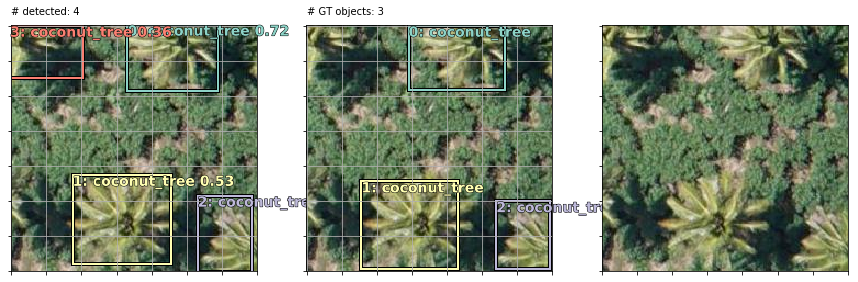

TP FP FN GTc   Category
3  1  0  3      coconut_tree (cat1)

NMS CONFIDENCE THRESHOLD: 0.35


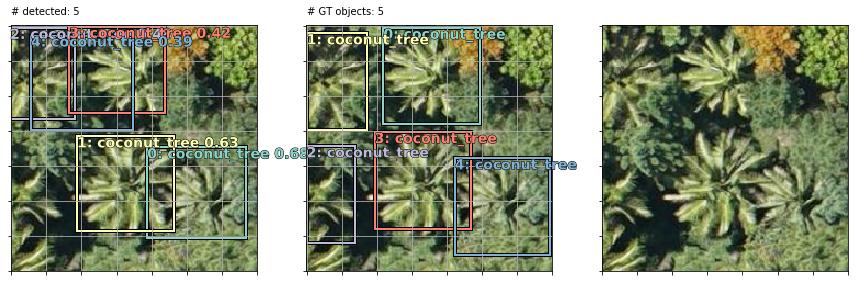

TP FP FN GTc   Category
4  1  1  5      coconut_tree (cat1)

NMS CONFIDENCE THRESHOLD: 0.35


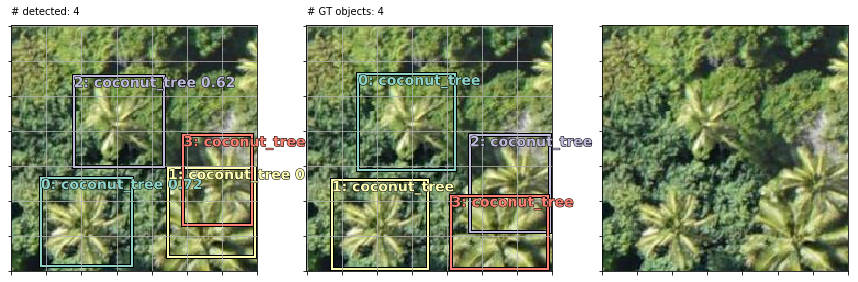

TP FP FN GTc   Category
4  0  0  4      coconut_tree (cat1)


In [82]:
rand_idx = np.random.randint(0,bs-10)
print(rand_idx)

threshrange = [best_md_thres]

for i in range(rand_idx,rand_idx+10):
    b_num = found_objs[i][0]
    idx = found_objs[i][1]
    show_foundobjs_threshrange(b_num, idx, threshrange, verbose=True)

# Different IoU Threshold

In [ ]:
n = 40
md_thres_rng = np.linspace(.05, 0.95, n, endpoint=True)
iou_thres = 0.3
cats = [1]

tps2, fps2, fns2, _ = all_tpfpfn(md_thres_rng, iou_thres, cats)

finished with batch 1
finished with batch 2
finished with batch 3
finished with batch 4
finished with batch 5
finished with batch 6
finished with batch 7
finished with batch 8


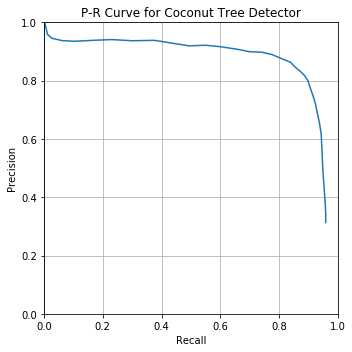

In [88]:
aps2 = []

fig, ax = plt.subplots(1,1,figsize=(5,5))
ap, precision, recall = calc_prec_reca(tps2, fps2, fns2, 1)
aps2.append(ap)
ax.plot(recall, precision)
ax.set_xlim(0,1.0)
ax.set_ylim(0,1.0)
ax.set_title(f'P-R Curve for Coconut Tree Detector')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(1)
plt.tight_layout()

In [89]:
aps2

[0.8302367040541849]

In [90]:
f1_2 = f1_score(precision, recall)
f1_2.max()

0.8518891687657429

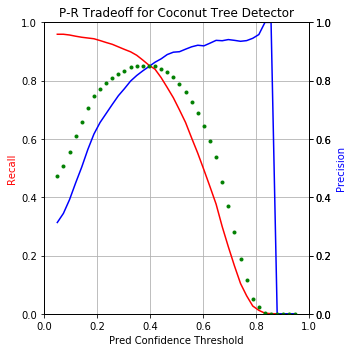

In [92]:
fig, ax1 = plt.subplots(1,1, figsize=(5,5))

ax1.set_xlim(0,1.0)
ax1.set_ylim(0,1.0)

ax1.grid(1)

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax2.set_xlim(0,1.0)
ax2.set_ylim(0,1.0)

ax1.plot(md_thres_rng, recall, 'r-')
ax2.plot(md_thres_rng, precision, 'b-')
ax3.plot(md_thres_rng, f1_2, '.g')

ax3.set_ylim(0,1.0)

ax1.set_title(f'P-R Tradeoff for Coconut Tree Detector')
ax1.set_xlabel('Pred Confidence Threshold')

ax1.set_ylabel('Recall', color='r')
ax2.set_ylabel('Precision', color='b')

plt.tight_layout()